# 02467 Computational Social Science
## Assignment 2
### Group 15

Our GitHub repo is availabe at: https://github.com/Simo067m/ComSocSci-Assignments <br>
Contribution:
- s233304 : Part 1 + 2
- s214592 : Part 3
- sxxxxxx : Part 1 + 2

In [8]:
# Import packages
import pandas as pd
import nltk
import networkx as nx
import ast
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import wordcloud

## Part 3 - Words that characterize Computational Social Science communities

# 1. <br>
## What is the point of TF-IDF
> - TF-IDF is useful as a measure of how important a word is to a corpus or collection of documents, by both taking account of how often it appears and keeping in mind that some words appear more frequently than others. This means that unique words of high importance to a corpus will have a larger value and less significant common words will have a smaller value.
## What does TF stand for?
> - TF stands for term frequency. It is a measure of how often a term appears within a corpus, relative to the total number of terms, and is therefore a relative frequency.
## What does IDF stand for?
> - IDF stands for inverse document frequency. It is a measure of how rare a word is across a corpus of documents, logarithmically scaled.

# 2.
## Now, we want to find out which words are important for each *community*, so we're going to create several ***large documents, one for each community***. Each document includes all the tokens of abstracts written by members of a given community. 

In [9]:
# Load data, removing NaN values if something is missing
authors = pd.read_csv("combined_authors_community.csv").dropna()
papers = pd.read_csv("papers.csv").dropna()
abstracts = pd.read_csv("abstracts_tokens.csv").dropna()

# Make sure that author_ids in papers is of type list and not str
papers["author_ids"] = papers["author_ids"].apply(ast.literal_eval)

# Make sure that tokens in abstracts is of type list and not str
abstracts["tokens"] = abstracts["tokens"].apply(ast.literal_eval)

# Explode papers to have one row per author
papers = papers.explode("author_ids")

In [10]:
# Define function for creating the community documents

def create_community_document(author_ids : list):
    # Find all papers written by authors in author_ids
    community_papers = []
    for author in author_ids:
        # Get papers written by author
        papers_written = papers[papers["author_ids"] == author]["id"]
        # Get tokenized abstracts of papers written by author
        for paper in papers_written:
            if paper not in community_papers:
                community_papers.append(paper)
    # Find all the abstract tokens of the papers
    community_abstract_tokens = []
    for paper in community_papers:
        abstract_tokens = abstracts[abstracts["id"] == paper]["tokens"].to_list()
        for token_list in abstract_tokens:
            for token in token_list:
                community_abstract_tokens.append(token)
    return community_abstract_tokens

In [11]:
# Create the documents
community_tokens = authors.groupby("community").apply(lambda x: create_community_document(x["id"].tolist()))

C:\Users\ssjsi\AppData\Local\Temp\ipykernel_22532\1399818203.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  community_tokens = authors.groupby("community").apply(lambda x: create_community_document(x["id"].tolist()))


# 3.
## Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within the __top 5 communities__ (by number of authors). 

In [12]:
# Define functions for finding TF-IDF scores

def term_frequency(tokens : list):
    # Find the frequency of each token
    frequency = nltk.FreqDist(tokens)
    # Find the total number of tokens
    total_tokens = len(tokens)
    # Find the frequency of each token
    term_frequency = {token : frequency[token] / total_tokens for token in frequency}
    return term_frequency

def inverse_document_frequency(documents : list):
    # Find the number of documents
    number_of_documents = len(documents)
    # Find the number of documents containing each token
    document_frequency = {}
    for document in documents:
        for token in set(document):
            if token not in document_frequency:
                document_frequency[token] = 1
            else:
                document_frequency[token] += 1
    # Find the inverse document frequency of each token
    inverse_document_frequency = {token : np.log10(number_of_documents / document_frequency[token]) for token in document_frequency}
    return inverse_document_frequency

def tf_idf(term_frequency : dict, inverse_document_frequency : dict):
    # Find the TF-IDF score of each token
    tf_idf = {token : term_frequency[token] * inverse_document_frequency[token] for token in term_frequency}
    return tf_idf

community_term_frequency = community_tokens.apply(term_frequency)

In [13]:
# Find the top 5 communities by author count
top_5_communities = authors["community"].value_counts().head(5).index.to_list()
print(f"Top 5 communities: {top_5_communities}")

top_5_community_tokens = community_tokens.loc[top_5_communities].copy()

print(f"Tokens from top 5 communities: {top_5_community_tokens}")

# Find TF and IDF scores for the top 5 communities
top_5_community_term_frequency = community_term_frequency.loc[top_5_communities].copy()

Top 5 communities: [1.0, 18.0, 25.0, 106.0, 5.0]
Tokens from top 5 communities: community
1.0      [thi, paper, examin, determin, social, distanc...
18.0     [latent, variabl, model, potenti, add, valu, l...
25.0     [investig, growth, c, facet, good, qualiti, he...
106.0    [thi, paper, investig, task, offload, problem,...
5.0      [loneli, wide, affect, mental, health, symptom...
dtype: object


Top 5 terms by TF for each of the top 5 communities

In [14]:
# Find top TF scores
top_5_community_tf = top_5_community_term_frequency.apply(lambda x: {token : x[token] for token in sorted(x, key = x.get, reverse = True)[:5]})
print(f"Top 5 token TF scores for community 1: {top_5_community_tf[1.0]}")
print(f"Top 5 token TF scores for community 18: {top_5_community_tf[18.0]}")
print(f"Top 5 token TF scores for community 25: {top_5_community_tf[25.0]}")
print(f"Top 5 token TF scores for community 106: {top_5_community_tf[106.0]}")
print(f"Top 5 token TF scores for community 5: {top_5_community_tf[5.0]}")

Top 5 token TF scores for community 1: {'network': 0.01355826215482569, 'social': 0.013487202080638971, 'thi': 0.011014311498941205, 'model': 0.010573739038983556, 'use': 0.008299816665008598}
Top 5 token TF scores for community 18: {'thi': 0.01352823283373998, 'network': 0.009868421052631578, 'social': 0.009302021610317185, 'model': 0.009084175670965493, 'use': 0.008169222725688393}
Top 5 token TF scores for community 25: {'network': 0.012965417520183155, 'thi': 0.012869020363899265, 'social': 0.009977105675382576, 'model': 0.008290155440414507, 'data': 0.008025063260633812}
Top 5 token TF scores for community 106: {'control': 0.013241928868576785, 'thi': 0.013183336262963615, 'propos': 0.012128669361926525, 'system': 0.011425558094568465, 'model': 0.009726372531786489}
Top 5 token TF scores for community 5: {'thi': 0.012295914910913894, 'social': 0.010974866201476864, 'network': 0.010399024456337646, 'user': 0.00978930966736671, 'use': 0.009518325316712959}


### Describe similarities and differences between the communities.
> * The first three communities contain the same words, but at different frequencies, where the latter two communities contain at least one different word from the first three. The clearly all relate to some kind of social network, social science and some kind of mode through the usage of the words "network", "social" and "model". The communities have few differences between them.
### Why aren't the TFs not necessarily a good description of the communities?
> * The TFs might not be a good description since it does not take the semantics of the terms into account and is prone to standard or common words having a high TF. In this case, we see that the word "model", a common word in many sciences, is very common. The same is the word "this" (stemmed to "thi"), which is simply a common word in the english language, and does not tell us anything about the communities.

### Next, we calculate IDF for every word. 
#### What base logarithm did you use? Is that important?
> * The used logarithm is the natural logarithm which is in base e, as this one is easier to understand if further mathematical computations were to be performed due to it's ease of derivative. The natural logarithm is also used in information theory.

In [15]:
# Calculate the IDF for every word
idf = inverse_document_frequency(community_tokens)

# 4. 
## We're ready to calculate TF-IDF. Do that for the __top 9 communities__ (by number of authors).

In [16]:
# Find the top 9 communities by author count
top_9_communities = authors["community"].value_counts().head(9).index.to_list()
print(f"Top 9 communities: {top_9_communities}")

top_9_community_tokens = community_tokens.loc[top_9_communities].copy()

print(f"Tokens from top 9 communities: {top_9_community_tokens}")

# Find TF and IDF scores for the top 9 communities
top_9_community_term_frequency = community_term_frequency.loc[top_9_communities].copy()

# Calculate TF-IDF
community_tf_idf = top_9_community_term_frequency.apply(lambda x: tf_idf(x, idf))

Top 9 communities: [1.0, 18.0, 25.0, 106.0, 5.0, 28.0, 34.0, 23.0, 57.0]
Tokens from top 9 communities: community
1.0      [thi, paper, examin, determin, social, distanc...
18.0     [latent, variabl, model, potenti, add, valu, l...
25.0     [investig, growth, c, facet, good, qualiti, he...
106.0    [thi, paper, investig, task, offload, problem,...
5.0      [loneli, wide, affect, mental, health, symptom...
28.0     [billion, user, onlin, social, network, repres...
34.0     [numer, model, dynam, respons, analysi, motion...
23.0     [introduc, friend, famili, studi, longitudin, ...
57.0     [studi, easi, distinguish, influenc, oper, org...
dtype: object


## Then for each community:
>   * List the 10 top TF words 
>   * List the 10 top TF-IDF words
>   * List the top 3 authors (by degree)

In [17]:
# Define function for finding the top 3 authors for a community
def find_top_3_authors(authors):
    # Find the top 3 authors
    top_3_authors = authors.sort_values(by = "degree", ascending = False).head(3)
    top = top_3_authors[["display_name", "degree"]]
    return top

In [18]:
# Define function for listing top 10 TF words, top 10 TF-IDF words, and top 3 authors by degree
def top_10_tf_top_10_tf_idf_top_3_authors(communities : list):
   top_10_tf = top_9_community_term_frequency.apply(lambda x: {token : x[token] for token in sorted(x, key = x.get, reverse = True)[:10]})
   top_10_tf_idf = community_tf_idf.apply(lambda x: {token : x[token] for token in sorted(x, key = x.get, reverse = True)[:10]})
   top_authors = authors.groupby("community").apply(find_top_3_authors)
   for community in communities:
      print(f"Scores for community {community}:")
      print(f"Top 10 token TF scores for community {community}: {top_10_tf[community]}")
      print(f"Top 10 token TF-IDF scores for community {community}: {top_10_tf_idf[community]}")
      print(f"Top 3 authors by degree for community {community}: {top_authors.loc[community]}")
      print("-------------------------------------------------------")

In [19]:
# Display the results
top_10_tf_top_10_tf_idf_top_3_authors(top_9_communities)

Scores for community 1.0:
Top 10 token TF scores for community 1.0: {'network': 0.01355826215482569, 'social': 0.013487202080638971, 'thi': 0.011014311498941205, 'model': 0.010573739038983556, 'use': 0.008299816665008598, 'data': 0.007575003908304081, 'studi': 0.006366982647129884, 'user': 0.00635277063229254, 'inform': 0.0057842900387988, 'differ': 0.0053437175788411525}
Top 10 token TF-IDF scores for community 1.0: {'network': 0.004519223183334119, 'social': 0.0038275136738508456, 'user': 0.0029799483379833016, 'epidem': 0.0026736291594161308, 'model': 0.0024081842019288554, 'bot': 0.0023753602130742405, 'dynam': 0.0021663055175665203, 'spread': 0.0021627552596133544, 'commun': 0.002063359774418618, 'media': 0.0019591286625792884}
Top 3 authors by degree for community 1.0:           display_name  degree
15459  Filippo Menczer   104.0
15856     Alain Barrat    94.0
16049   Emilio Ferrara    86.0
-------------------------------------------------------
Scores for community 18.0:
Top 10 

C:\Users\ssjsi\AppData\Local\Temp\ipykernel_22532\1176741724.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_authors = authors.groupby("community").apply(find_top_3_authors)


## Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?
> * The words with highest TF-IDF are clearly a lot more descriptive than the TF-words. As seen previously, the TF words were all very similar across the communities, since they were simply common words appearing frequently. The inclusion of IDF and how common a word generally is, means that we can actually see sort of what the community is working with from the TF-IDF words, as they now differ greatly for each community, only generally sharing words like "network", "social" and "model", which is expected from social science.

# Wordcloud visualization

C:\Users\ssjsi\AppData\Local\Temp\ipykernel_22532\2285471088.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_authors = authors.groupby("community").apply(find_top_3_authors)


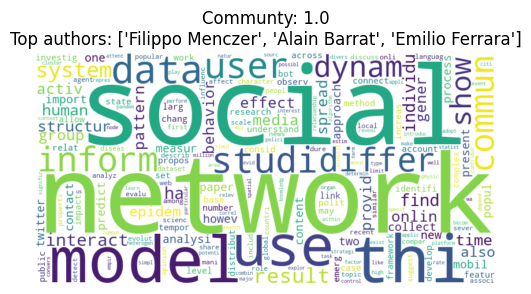

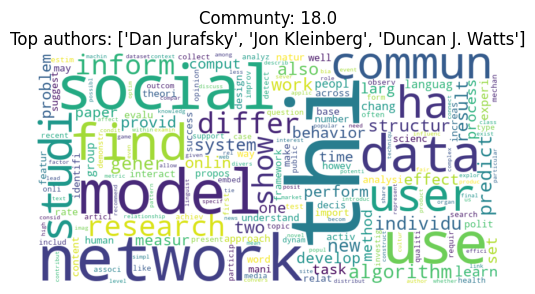

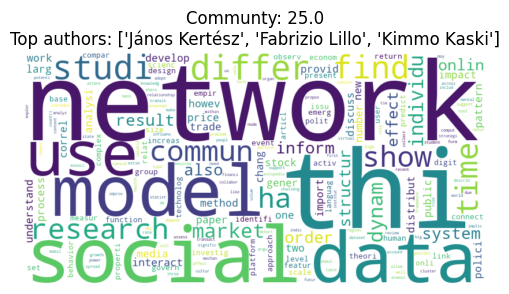

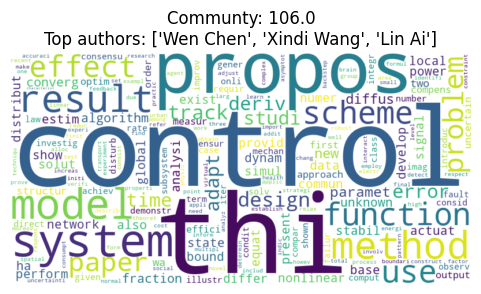

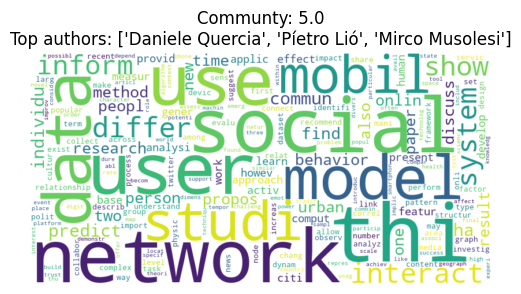

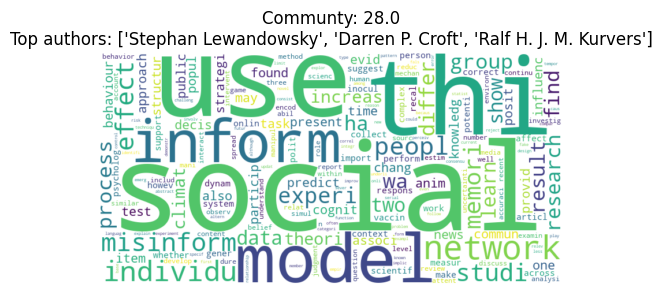

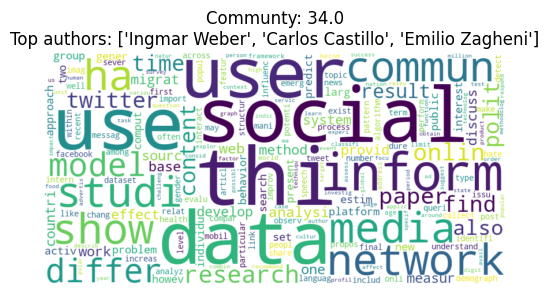

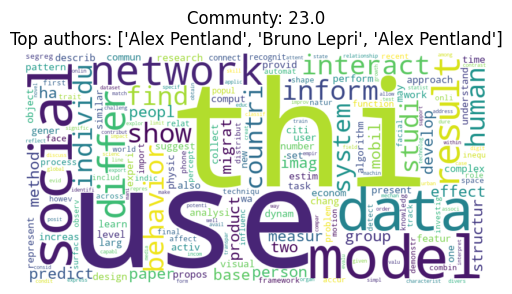

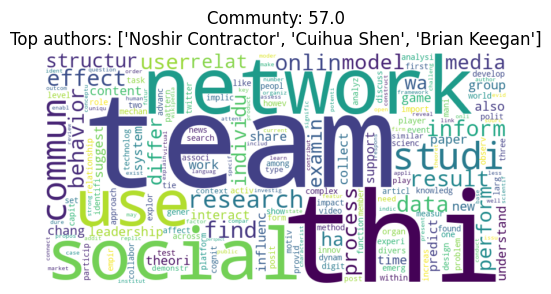

In [20]:
# Define function for creating a word cloud
def create_word_cloud(tokens : list):
    # Find the frequency of each token
    frequency = nltk.FreqDist(tokens)
    # Create a word cloud
    cloud = wordcloud.WordCloud(width = 800, height = 400, background_color = "white").generate_from_frequencies(frequency)
    return cloud

# Define a function for plotting the word cloud
def plot_word_cloud(cloud : wordcloud.WordCloud, top_authors, community_idx):
    plt.figure(figsize = (6, 3))
    plt.imshow(cloud, interpolation = "bilinear")
    plt.axis("off")
    plt.title(f"Communty: {community_idx}\nTop authors: {top_authors}")
    plt.show()

top_authors = authors.groupby("community").apply(find_top_3_authors)

# Create a word cloud for the top 9 communities
top_9_community_word_clouds = top_9_community_tokens.apply(create_word_cloud)
for community in top_9_communities:
    plot_word_cloud(top_9_community_word_clouds[community], top_authors.loc[community, "display_name"].to_list(), community)

> * The wordsclouds show the top 9 communities. They tell us something about the subtle differences between the sub-communities. The word social is very common across them, and so is network and model. However, some have social and media, some have social and team, some have social and network. One community has control as a top word.

### Look up online the top author in each community. In light of your search, do your results make sense?
> * Looking up the top author for community 1 and 106, which respectively are characterized by "social, network, model" and "control, system". Looking up the top author of community 1, Filippo Menczer, his work is focused on social networks, social media and data science, which perfectly matches the community. Looking up the top author of community 106, Wen Chen, works on system control and modeling, which also matches the community. The results make great sense.

### In light of your data-driven analysis, has your understanding of the field changed? How? __(max 150 words)__
> * The field of social science is very broad, where originally we believed it was mostly concerned with the study of social interactions as a broad description. However, the fact that so many communities could be made with differing main topics proves the broadness of the field. Our understanding of the size of the field has changed too, since it was possible to collect such a large number of authors and papers which all relate to the field, which all had many similar ideas, which is natural for papers in the same field, but also differed greatly in content, as proven by this analysis.